In [97]:
%reload_ext autoreload 
%autoreload 2

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import random 
import time
from utils import Dataset,ProgressBar
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
from tflearn.data_utils import Preloader,ImagePreloader
import scipy
import pandas as pd
import xmltodict
import common
import tflearn
import copy
from cchess import *
from game_convert import convert_game,convert_game_value,convert_game_board

In [2]:
!nvidia-smi

Sat May  5 23:11:24 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 43%   73C    P2    98W / 250W |   5967MiB / 11172MiB |     96%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:42:00.0 Off |                  N/A |
| 25%   44C    P8    17W / 250W |    169MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# a network predict select and move of Chinese chess, with minimal preprocessing

In [3]:
GPU_CORE = [1]
BATCH_SIZE = 256
BEGINING_LR = 0.01
#TESTIMG_WIDTH = 500
model_name = '5_5_resnet_joint'
data_dir = 'data/imsa-cbf/'

In [4]:
labels = common.board.create_uci_labels()
label2ind = dict(zip(labels,list(range(len(labels)))))

In [5]:
pgn2value = dict(pd.read_csv('./data/resultlist.csv').values[:,1:])

In [6]:
class ElePreloader(object):
    def __init__(self,datafile,batch_size=64):
        self.batch_size=batch_size
        content = pd.read_csv(datafile,header=None,index_col=None)
        self.filelist = [i[0] for i in content.get_values()]
        self.pos = 0
        self.feature_list = {"red":['A', 'B', 'C', 'K', 'N', 'P', 'R']
                             ,"black":['a', 'b', 'c', 'k', 'n', 'p', 'r']}
        self.batch_size = batch_size
        self.batch_iter = self.__iter()
        assert(len(self.filelist) > batch_size)
        self.game_iterlist = [None for i in self.filelist]
    
    def __iter(self):
        retx1,rety1,retx2,rety2 = [],[],[],[]
        vals = []
        filelist = []
        while True:
            for i in range(self.batch_size):
                if self.game_iterlist[i] == None:
                    if len(filelist) == 0:
                        filelist = copy.copy(self.filelist)
                        random.shuffle(filelist)
                    self.game_iterlist[i] = convert_game_value(filelist.pop(),self.feature_list,pgn2value)
                game_iter = self.game_iterlist[i]
                
                try:
                    x1,y1,val1 = game_iter.__next__()
                    x1 = np.transpose(x1,[1,2,0])
                    x1 = np.expand_dims(x1,axis=0)
                    retx1.append(x1)
                    #rety1.append(y1)
                    oney = np.zeros(len(labels))
                    oney[label2ind[''.join(y1)]] = 1
                    rety1.append(oney)
                    vals.append(val1)

                    if len(retx1) >= self.batch_size:
                        yield (np.concatenate(retx1,axis=0),np.asarray(rety1),np.asarray(vals))
                        retx1,rety1 = [],[]
                        vals = []
                except :
                    self.game_iterlist[i] = None

    def __getitem__(self, id):
        
        x1,y1,val1 = self.batch_iter.__next__()
        return x1,y1,val1
        
    def __len__(self):
        return 10000

In [7]:
trainset = ElePreloader(datafile='data/train_list.csv',batch_size=BATCH_SIZE)
with tf.device("/gpu:{}".format(GPU_CORE[0])):
    coord = tf.train.Coordinator()
    trainflow = FeedDictFlow({
            'data':trainset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True,num_threads=1)
trainflow.start()

In [8]:
testset = ElePreloader(datafile='data/test_list.csv',batch_size=BATCH_SIZE)
with tf.device("/gpu:{}".format(GPU_CORE[0])):
    coord = tf.train.Coordinator()
    testflow = FeedDictFlow({
            'data':testset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True,num_threads=1)
testflow.start()

In [9]:
sample_x1,sample_y1,sample_value = trainflow.next()['data']

In [15]:
sample_x1,sample_y1,sample_value = testflow.next()['data']

In [16]:
sample_x1.shape,sample_y1.shape,sample_value.shape

((256, 10, 9, 14), (256, 2086), (256,))

In [17]:
labels[np.argmax(sample_y1[0])]

'b0c2'

In [18]:
np.sum(sample_x1[0],axis=-1)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint64)

In [19]:
sample_value[:10]

array([ 1., -1.,  1., -0., -0., -1., -0., -1., -0., -1.])

In [20]:
len(labels)

2086

In [22]:
np.sum(sample_x1[0],axis=-1).shape

(10, 9)

In [23]:
def res_block(inputx,name,training,block_num=2,filters=256,kernel_size=(3,3)):
    net = inputx
    for i in range(block_num):
        net = tf.layers.conv2d(net,filters=filters,kernel_size=kernel_size,activation=None,name="{}_res_conv{}".format(name,i),padding='same')
        net = tf.layers.batch_normalization(net,training=training,name="{}_res_bn{}".format(name,i))
        if i == block_num - 1:
            net = net + inputx #= tf.concat((inputx,net),axis=-1)
        net = tf.nn.elu(net,name="{}_res_elu{}".format(name,i))
    return net

def conv_block(inputx,name,training,block_num=1,filters=2,kernel_size=(1,1)):
    net = inputx
    for i in range(block_num):
        net = tf.layers.conv2d(net,filters=filters,kernel_size=kernel_size,activation=None,name="{}_convblock_conv{}".format(name,i),padding='same')
        net = tf.layers.batch_normalization(net,training=training,name="{}_convblock_bn{}".format(name,i))
        net = tf.nn.elu(net,name="{}_convblock_elu{}".format(name,i))
    # net [None,10,9,2]
    netshape = net.get_shape().as_list()
    print("inside conv block {}".format(str(netshape)))
    net = tf.reshape(net,shape=(-1,netshape[1] * netshape[2] * netshape[3]))
    net = tf.layers.dense(net,10 * 9,name="{}_dense".format(name))
    net = tf.nn.elu(net,name="{}_elu".format(name))
    return net

def res_net_board(inputx,name,training,filters=256):
    net = inputx
    net = tf.layers.conv2d(net,filters=filters,kernel_size=(3,3),activation=None,name="{}_res_convb".format(name),padding='same')
    net = tf.layers.batch_normalization(net,training=training,name="{}_res_bnb".format(name))
    net = tf.nn.elu(net,name="{}_res_elub".format(name))
    for i in range(NUM_RES_LAYERS):
        net = res_block(net,name="{}_layer_{}".format(name,i + 1),training=training)
        print(net.get_shape().as_list())
    print("inside res net {}".format(str(net.get_shape().as_list())))
    #net_unsoftmax = conv_block(net,name="{}_conv".format(name),training=training)
    return net

def get_scatter(name):
    with tf.variable_scope("Test"):
        ph = tf.placeholder(tf.float32,name=name)
        op = tf.summary.scalar(name,ph)
    return ph,op

In [24]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.


    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

def add_grad_to_list(opt,train_param,loss,tower_grad):
    grads = opt.compute_gradients(loss, var_list = train_param)
    grads = [i[0] for i in grads]
    #print(grads)
    tower_grad.append(zip(grads,train_param))
    
def get_op_mul(tower_gradients,optimizer,gs):
    grads = average_gradients(tower_gradients)
    train_op = optimizer.apply_gradients(grads,gs)
    return train_op

def reduce_mean(x):
    return tf.reduce_mean(x)

def merge(x):
    return tf.concat(x,axis=0)

In [25]:
GPU_CORE

[1]

In [26]:
tf.reset_default_graph()

NUM_RES_LAYERS = 4

graph = tf.Graph()
with graph.as_default():
#with tf.device("/gpu:{}".format(GPU_CORE)):
    X = tf.placeholder(tf.float32,[None,10,9,14])
    nextmove = tf.placeholder(tf.float32,[None,len(labels)])
    score = tf.placeholder(tf.float32,[None,1])
    
    training = tf.placeholder(tf.bool,name='training_mode')
    learning_rate = tf.placeholder(tf.float32)
    global_step = tf.train.get_or_create_global_step()
    optimizer_policy = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    optimizer_value = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    optimizer_multitarg = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    
    tower_gradients_policy,tower_gradients_value,tower_gradients_multitarg = [],[],[]
    
    net_softmax_collection = []
    value_head_collection = []
    multitarget_loss_collection = []
    value_loss_collection = []
    policy_loss_collection = []
    accuracy_select_collection = []
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for ind,one_core in enumerate(GPU_CORE):
            with tf.device("/gpu:{}".format(one_core)):
                print(ind)
                body = res_net_board(X[ind * (BATCH_SIZE // len(GPU_CORE)):(ind + 1) * (BATCH_SIZE // len(GPU_CORE))],
                                     "selectnet",training=training)
                with tf.variable_scope("policy_head"):
                    policy_head = tf.layers.conv2d(body, 2, 1, padding='SAME')
                    policy_head = tf.contrib.layers.batch_norm(policy_head, center=False, epsilon=1e-5, fused=True,
                                                                is_training=training, activation_fn=tf.nn.relu)

                    # print(self.policy_head.shape)  # (?, 9, 10, 2)
                    policy_head = tf.reshape(policy_head, [-1, 9 * 10 * 2])
                    policy_head = tf.contrib.layers.fully_connected(policy_head, len(labels), activation_fn=None)
                    #self.policy_head.append(policy_head)    # 保存多个gpu的策略头结果（走子概率向量）

                # 价值头
                with tf.variable_scope("value_head"):
                    value_head = tf.layers.conv2d(body, 1, 1, padding='SAME')
                    value_head = tf.contrib.layers.batch_norm(value_head, center=False, epsilon=1e-5, fused=True,
                                                    is_training=training, activation_fn=tf.nn.relu)
                    # print(self.value_head.shape)  # (?, 9, 10, 1)
                    value_head = tf.reshape(value_head, [-1, 9 * 10 * 1])
                    value_head = tf.contrib.layers.fully_connected(value_head, 256, activation_fn=tf.nn.relu)
                    value_head = tf.contrib.layers.fully_connected(value_head, 1, activation_fn=tf.nn.tanh)
                    value_head_collection.append(value_head)
                net_unsoftmax = policy_head

                with tf.variable_scope("Loss"):
                    policy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                        labels=nextmove[ind * (BATCH_SIZE // len(GPU_CORE)):(ind + 1) * (BATCH_SIZE // len(GPU_CORE))],
                        logits=net_unsoftmax))
                    #loss_summary = tf.summary.scalar("move_loss",policy_loss)
                    value_loss = tf.losses.mean_squared_error(
                        labels=score[ind * (BATCH_SIZE // len(GPU_CORE)):(ind + 1) * (BATCH_SIZE // len(GPU_CORE))],
                        predictions=value_head) 
                    value_loss = tf.reduce_mean(value_loss)
                    regularizer = tf.contrib.layers.l2_regularizer(scale=0.0001)
                    regular_variables = tf.trainable_variables()
                    l2_loss = tf.contrib.layers.apply_regularization(regularizer, regular_variables)
                    multitarget_loss = value_loss + policy_loss + l2_loss
                    
                    multitarget_loss_collection.append(multitarget_loss)
                    value_loss_collection.append(value_loss)
                    policy_loss_collection.append(policy_loss)
                net_softmax = tf.nn.softmax(net_unsoftmax)
                net_softmax_collection.append(net_softmax)
                
                correct_prediction = tf.equal(tf.argmax(nextmove,1), tf.argmax(net_softmax,1))

                with tf.variable_scope("Accuracy"):
                    accuracy_select = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                    accuracy_select_collection.append(accuracy_select)
                tf.get_variable_scope().reuse_variables()
                trainable_params = tf.trainable_variables()
                tp_policy = [i for i in trainable_params if 
                                    ('value_head' not in i.name)]
                tp_value = [i for i in trainable_params if 
                                    ('policy_head' not in i.name)]

                add_grad_to_list(optimizer_policy,tp_policy,policy_loss,tower_gradients_policy)
                add_grad_to_list(optimizer_value,tp_value,value_loss,tower_gradients_value)
                add_grad_to_list(optimizer_multitarg,trainable_params,multitarget_loss,tower_gradients_multitarg)
               
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        #gradients_policy = average_gradients(tower_gradients_policy)
        train_op_policy = get_op_mul(tower_gradients_policy,optimizer_policy,global_step)
        train_op_value = get_op_mul(tower_gradients_value,optimizer_value,global_step)
        train_op_multitarg = get_op_mul(tower_gradients_multitarg,optimizer_multitarg,global_step)
        #train_op = optimizer.minimize(policy_loss,global_step=global_step)
    net_softmax = merge(net_softmax_collection)
    value_head = merge(value_head_collection)
    multitarget_loss = reduce_mean(multitarget_loss_collection)
    value_loss = reduce_mean(value_loss_collection)
    policy_loss = reduce_mean(policy_loss_collection)
    accuracy_select = reduce_mean(accuracy_select_collection)

0
[None, 10, 9, 256]
[None, 10, 9, 256]
[None, 10, 9, 256]
[None, 10, 9, 256]
inside res net [None, 10, 9, 256]


In [42]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    
    tf.train.global_step(sess, global_step)

In [43]:
!mkdir models

mkdir: 无法创建目录"models": 文件已存在


In [44]:
import os
if not os.path.exists("models/{}".format(model_name)):
    os.mkdir("models/{}".format(model_name))

In [45]:
N_BATCH = 10000 * (128 / BATCH_SIZE)
N_BATCH_TEST = 300 * (128 / BATCH_SIZE)
N_BATCH = int(N_BATCH)
N_BATCH_TEST = int(N_BATCH_TEST)

In [46]:
N_BATCH,N_BATCH_TEST

(5000, 150)

In [47]:
ind * (BATCH_SIZE // len(GPU_CORE)),(ind + 1) * (BATCH_SIZE // len(GPU_CORE))

(0, 256)

In [48]:
restore = False
N_EPOCH = 100
DECAY_EPOCH = 15

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
expacc_move = ExpVal()
exploss = ExpVal()
expsteploss = ExpVal()

begining_learning_rate = 1e-1

pred_image = None
if restore == False:
    train_epoch = 1
    train_batch = 0
for one_epoch in range(train_epoch + 1,N_EPOCH):
    train_epoch = one_epoch
    pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE,info=" epoch {} batch {}".format(train_epoch,train_batch))
    pb.startjob()
    
    for one_batch in range(N_BATCH):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(BATCH_SIZE)
            pb.auto_display = True
            continue
        else:
            restore = False
        train_batch = one_batch
        
        batch_x,batch_y,batch_v = trainflow.next()['data']
        batch_v = np.expand_dims(np.nan_to_num(batch_v),1)
        # learning rate decay strategy
        batch_lr = begining_learning_rate * 2 ** -(one_epoch // DECAY_EPOCH)
        with graph.as_default():
            _,step_loss,step_value_loss,step_acc_move,step_value,step_val_predict = sess.run(
                [train_op_multitarg,policy_loss,value_loss,accuracy_select,global_step,value_head],feed_dict={
                    X:batch_x,nextmove:batch_y,learning_rate:batch_lr,training:True,score:batch_v,
                })
        
        step_acc_move *= 100
        
        expacc_move.update(step_acc_move)
        exploss.update(step_loss)
        expsteploss.update(step_value_loss)

       
        pb.info = "EPOCH {} STEP {} LR {} ACC {} LOSS {} value_loss {}".format(
            one_epoch,one_batch,batch_lr,expacc_move.getval(),exploss.getval(),expsteploss.getval())
        
        pb.complete(BATCH_SIZE)
    print()
    pb = ProgressBar(worksum=N_BATCH // 4 * BATCH_SIZE,info=" epoch {}".format(train_epoch))
    pb.startjob()
    losses = []
    value_losses = []
    accs = []
    for one_batch in range(N_BATCH // 4):
        batch_x,batch_y,batch_v = testflow.next()['data']
        batch_v = np.expand_dims(np.nan_to_num(batch_v),1)
        # learning rate decay strategy
        batch_lr = begining_learning_rate * 10 ** -(one_epoch // DECAY_EPOCH)
        with graph.as_default():
            step_loss,step_value_loss,step_acc_move,step_value = sess.run(
                [policy_loss,value_loss,accuracy_select,global_step],feed_dict={
                    X:batch_x,nextmove:batch_y,learning_rate:batch_lr,training:False,score:batch_v,
                })
        
        step_acc_move *= 100
        losses.append(step_loss)
        accs.append(step_acc_move)
        value_losses.append(step_value_loss)
        pb.complete(BATCH_SIZE)
    print("EPOCH {} valid loss {} value loss {} acc {}".format(train_epoch,np.average(losses)
                                                               ,np.average(value_losses),np.average(accs)))
    print()
    with graph.as_default():
        saver = tf.train.Saver(var_list=tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(model_name,one_epoch))

EPOCH 2 STEP 4999 LR 0.1 ACC 24.85 LOSS 2.96 value_loss 0.51 100.00 % [==================================================>] 1280000/1280000 	 used:836s eta:0 ssd:0s eta:1769 s
 epoch 2 100.00 % [==================================================>] 320000/320000 	 used:212s eta:0 sEPOCH 2 valid loss 3.0058321952819824 value loss 0.6265491247177124 acc 24.8265625

EPOCH 3 STEP 4999 LR 0.1 ACC 27.47 LOSS 2.82 value_loss 0.53 100.00 % [==================================================>] 1280000/1280000 	 used:847s eta:0 ss
 epoch 3 100.00 % [==================================================>] 320000/320000 	 used:213s eta:0 sEPOCH 3 valid loss 2.8660829067230225 value loss 0.6357787847518921 acc 26.7171875

EPOCH 4 STEP 4999 LR 0.1 ACC 29.56 LOSS 2.72 value_loss 0.51 100.00 % [==================================================>] 1280000/1280000 	 used:844s eta:0 ss
 epoch 4 100.00 % [==================================================>] 320000/320000 	 used:211s eta:0 sEPOCH 4 valid loss 

KeyboardInterrupt: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa746623e80>]], dtype=object)

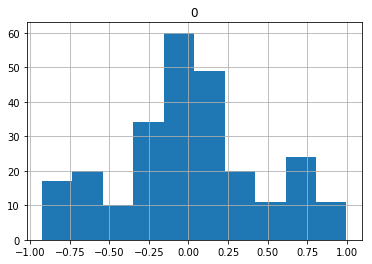

In [53]:
%matplotlib inline
pd.DataFrame(step_val_predict.reshape(-1)).hist()

In [230]:
ind = 122

In [231]:
gi = convert_game_value(testset.filelist[ind],testset.feature_list,pgn2value)

In [232]:
gb = convert_game_board(testset.filelist[ind],testset.feature_list,pgn2value)


In [233]:
np.concatenate((x1[:,::-1,:,7:],x1[:,::-1,:,:7]),axis=-1).shape,x1.shape

((1, 10, 9, 14), (1, 10, 9, 14))

In [234]:
pred1[0][0]

array([ 0.89351112], dtype=float32)

In [235]:
red = False
xx = 0
while True:
    xx += 1
    red = not red
    bx,ba,bb = gi.__next__()
    board_status,move = gb.__next__()

    #print(np.sum(bx,axis=0))
    x1 = np.transpose(bx,[1,2,0])
    x1 = np.expand_dims(x1,axis=0)

    x2 = np.concatenate((x1[:,::-1,:,7:],x1[:,::-1,:,:7]),axis=-1)
    board_status.print_board()

    with graph.as_default():
        pred = sess.run(
            [value_head],feed_dict={
                X:x1,training:False,
            })
        pred1 = sess.run(
            [value_head],feed_dict={
                X:x2,training:False,
            })
    pred = (pred[0][0] - pred1[0][0]) / 2
    if red:
        print(xx,pred,bb,move)
    else:
        print(xx, - pred,-bb,move)


0 砗─碼─象─士─将─士─象─碼─砗
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─砲─┼─┼─┼─┼─┼─砲─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─卒─┼─卒─┼─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─┴─┴─┴─┴─┴─┤
  │　                         　 │
5 ├─┬─┬─┬─┬─┬─┬─┬─┤
  │　│　│　│　│　│　│　│　│
6 兵─┼─兵─┼─兵─┼─兵─┼─兵
  │　│　│　│　│　│　│　│　│
7 ├─炮─┼─┼─┼─┼─┼─炮─┤
  │　│　│　│＼│／│　│　│　│
8 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 车─马─相─仕─帅─仕─相─马─车
  0   1   2   3   4   5   6   7   8

1 [ 0.] -1.0 (2, 6, 2, 5)

0 砗─碼─象─士─将─士─象─碼─砗
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─砲─┼─┼─┼─┼─┼─砲─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─卒─┼─卒─┼─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─┴─┴─┴─┴─┴─┤
  │　                         　 │
5 ├─┬─兵─┬─┬─┬─┬─┬─┤
  │　│　│　│　│　│　│　│　│
6 兵─┼─┼─┼─兵─┼─兵─┼─兵
  │　│　│　│　│　│　│　│　│
7 ├─炮─┼─┼─┼─┼─┼─炮─┤
  │　│　│　│＼│／│　│　│　│
8 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 车─马─相─仕─帅─仕─相─马─车
  0   1   2   3   4   5   6   7   8

2 [ 0.17255652] -1.0 (1, 2, 2, 2)

0 砗─碼─象─士─将─士─象─碼─砗
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　

33 [-0.42164022] -1.0 (4, 7, 4, 3)

0 ┌─砗─┬─士─将─士─象─┬─┐
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─※─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─┼─┼─┼─象─碼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─炮─┼─砲─车─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─┴─┴─砗─卒─┴─┤
  │　                         　 │
5 ├─┬─兵─┬─┬─┬─┬─┬─┤
  │　│　│　│　│　│　│　│　│
6 兵─┼─┼─┼─兵─┼─砲─┼─兵
  │　│　│　│　│　│　│　│　│
7 ├─┼─┼─车─┼─┼─马─┼─相
  │　│　│　│＼│／│　│　│　│
8 ├─┼─┼─┼─仕─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 └─┴─相─炮─帅─仕─┴─┴─┘
  0   1   2   3   4   5   6   7   8

34 [-0.00168143] -1.0 (3, 0, 4, 1)

0 ┌─砗─┬─┬─将─士─象─┬─┐
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─士─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─┼─┼─┼─象─碼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─炮─┼─砲─车─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─┴─┴─砗─卒─┴─┤
  │　                         　 │
5 ├─┬─兵─┬─┬─┬─┬─┬─┤
  │　│　│　│　│　│　│　│　│
6 兵─┼─┼─┼─兵─┼─砲─┼─兵
  │　│　│　│　│　│　│　│　│
7 ├─┼─┼─车─┼─┼─马─┼─相
  │　│　│　│＼│／│　│　│　│
8 ├─┼─┼─┼─仕─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 └─┴─相─炮─帅─仕─┴─┴─┘
  0   1   2   3   4   5   6   7   8

35 [-0.00900277] -1.0 (7, 3, 7, 5)

0 ┌─砗─┬─┬─将─士─象─┬─┐
  │  │

1 ├─┼─┼─┼─士─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─┼─┼─┼─象─┼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─砗─炮─车─┼─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─车─┴─┴─┴─┴─┤
  │　                         　 │
5 兵─┬─兵─┬─┬─┬─┬─┬─碼
  │　│　│　│　│　│　│　│　│
6 ├─┼─┼─┼─砲─┼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
7 ├─┼─┼─┼─相─马─┼─┼─┤
  │　│　│　│＼│／│　│　│　│
8 砗─┼─┼─炮─仕─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 └─┴─┴─┴─帅─仕─相─砲─┘
  0   1   2   3   4   5   6   7   8

68 [-0.79606199] -1.0 (0, 8, 0, 9)

0 ┌─┬─┬─┬─将─士─象─┬─┐
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─士─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─┼─┼─┼─象─┼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
3 卒─┼─卒─┼─砗─炮─车─┼─卒
  │　│　│　│　│　│　│　│　│
4 ├─┴─┴─车─┴─┴─┴─┴─┤
  │　                         　 │
5 兵─┬─兵─┬─┬─┬─┬─┬─碼
  │　│　│　│　│　│　│　│　│
6 ├─┼─┼─┼─砲─┼─┼─┼─┤
  │　│　│　│　│　│　│　│　│
7 ├─┼─┼─┼─相─马─┼─┼─┤
  │　│　│　│＼│／│　│　│　│
8 ├─┼─┼─炮─仕─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
9 砗─┴─┴─┴─帅─仕─相─砲─┘
  0   1   2   3   4   5   6   7   8

69 [-0.88368022] -1.0 (3, 8, 3, 9)

0 ┌─┬─┬─┬─将─士─象─┬─┐
  │  │  │  │＼│／│　│　│　│
1 ├─┼─┼─┼─士─┼─┼─┼─┤
  │　│　│　│／│＼│　│　│　│
2 ├─┼─┼─┼─象─┼─┼─┼─┤
  

StopIteration: 

In [221]:
bb,red

(-0.0, True)

In [222]:
print(open(testset.filelist[ind]).read())

﻿<?xml version="1.0" encoding="UTF-8"?>
<ChineseChessRecord Version="1.0">
 <Head>
  <Name>no</Name>
  <URL />
  <From>405761.pgn</From>
  <ContestType />
  <Contest />
  <Round>第 9 轮</Round>
  <Group />
  <Table />
  <Date>2014-12-06</Date>
  <Site> </Site>
  <TimeRule />
  <Red>侯文博</Red>
  <RedTeam>河北</RedTeam>
  <RedTime />
  <RedRating />
  <Black>王浩楠</Black>
  <BlackTeam>杭州棋类学</BlackTeam>
  <BlackTime />
  <BlackRating />
  <Referee />
  <Recorder />
  <Commentator />
  <CommentatorURL />
  <Creator />
  <CreatorURL />
  <DateCreated />
  <DateModified>2017-11-04 18:22:56</DateModified>
  <ECCO>E02</ECCO>
  <RecordType>1</RecordType>
  <RecordKind />
  <RecordResult>0</RecordResult>
  <ResultType />
  <FEN>rnbakabnr/9/1c5c1/p1p1p1p1p/9/9/P1P1P1P1P/1C5C1/9/RNBAKABNR w - - 0 1</FEN>
 </Head>
 <MoveList>
  <Move value="00-00" />
  <Move value="26-25" />
  <Move value="20-42" />
  <Move value="19-27" />
  <Move value="63-64" />
  <Move value="17-07" />
  <Move value="10-22" />
  <Move

In [223]:
print(open('data/imsa_play/405761.pgn',encoding='gbk').read())


    [Game "Chinese Chess"]
    [Event "no"]
    [Site " "]
    [Seesion "1"]
    [Date "2014-12-06"]
    [Round "第 9 轮"]
    [Red "侯文博"]
    [RedTeam "河北"]
    [Black "王浩楠"]
    [BlackTeam "杭州棋类学"]
    [Result 红和]
    1.兵七进一 象3进5

2.马八进七 卒7进1

3.炮八平九 马2进3

4.车九平八 车1平2

5.马二进三 马8进7

6.车八进六 车9进1

7.车一进一 车9平6

8.相三进五 炮8进1

9.车八退二 炮8平7

10.兵三进一 卒7进1

11.相五进三 车6进5

12.马三进二 炮7进1

13.相三退一 车6平8

14.马二进三 车8退3

15.炮二平三 卒3进1

16.兵七进一 象5进3

17.车八平三 车8平7

18.炮三进三 士4进5

19.马七进六 象7进9

20.炮三进二 车7进2

21.相一进三 炮2平7

22.车一平七 车2平4

23.马六进四 炮7进2

24.炮九平二 车4进2

25.车七进三 象9退7

26.相三退五 车4进2

27.车七平四 象3退5

28.仕四进五 马3进2

29.炮二进三 卒5进1

30.车四平三 车4进1

31.马四进五 车4平7

32.马五进三 将5平4

33.相五进三 马2进1

34.相三退五 炮7退2


    
